<a href="https://colab.research.google.com/github/j1mmyjang/portfolio/blob/main/rfm_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('transaction_data.csv',encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Created TotalCost  to assess monatary value of each customer and

In [ ]:
# Create 'TotalCost' column to determine montary value of each transaction
df['TotalCost'] = df['Quantity']*df['UnitPrice']

# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Store most recent transaction date to calculate regency of each transaction
reference_date = df['InvoiceDate'].max()

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
# Group dataframe by 'CustomerID' column to create subsets of data for each unique customer
rfm = df.groupby('CustomerID').agg({

    # Apply a lambda function to calculate how recently each customer group made a purchase by subtracting the maximum invoice date from the reference date
    'InvoiceDate': lambda x: (reference_date - x.max()).days,

    # Apply a nunique function to count how many transactions each customer has made
    'InvoiceNo': 'nunique',

    # Apply a sum function to calculate the total monetary value of each customer's transactions
    'TotalCost': 'sum'
})

rfm = rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalCost':'Monetary Value'})
rfm.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

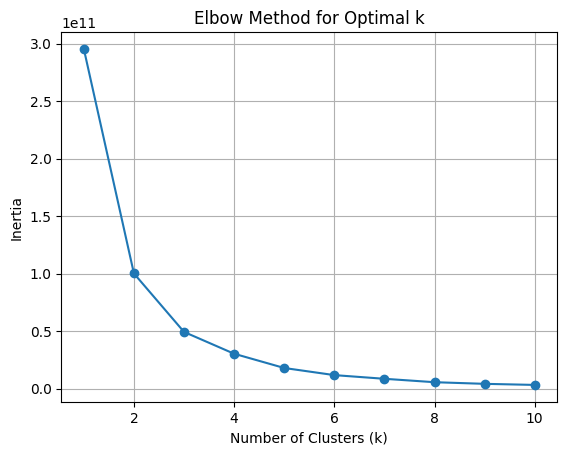

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

inertia = []

k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(rfm)
    inertia.append(kmeans.inertia_)

# Plot inertia values against the number of clusters (k)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

The elbow of the curve is at 4 where the rate of decrease in inertia sharply changes. Adding more than 4 clusters does not significantly reduce the sum of squared distances, indicating an optimal number of clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(rfm)

rfm['Cluster'] = kmeans.labels_

rfm.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary Value,Cluster
CustomerID,,,,
12346.0,325,2,0.00,0
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,0


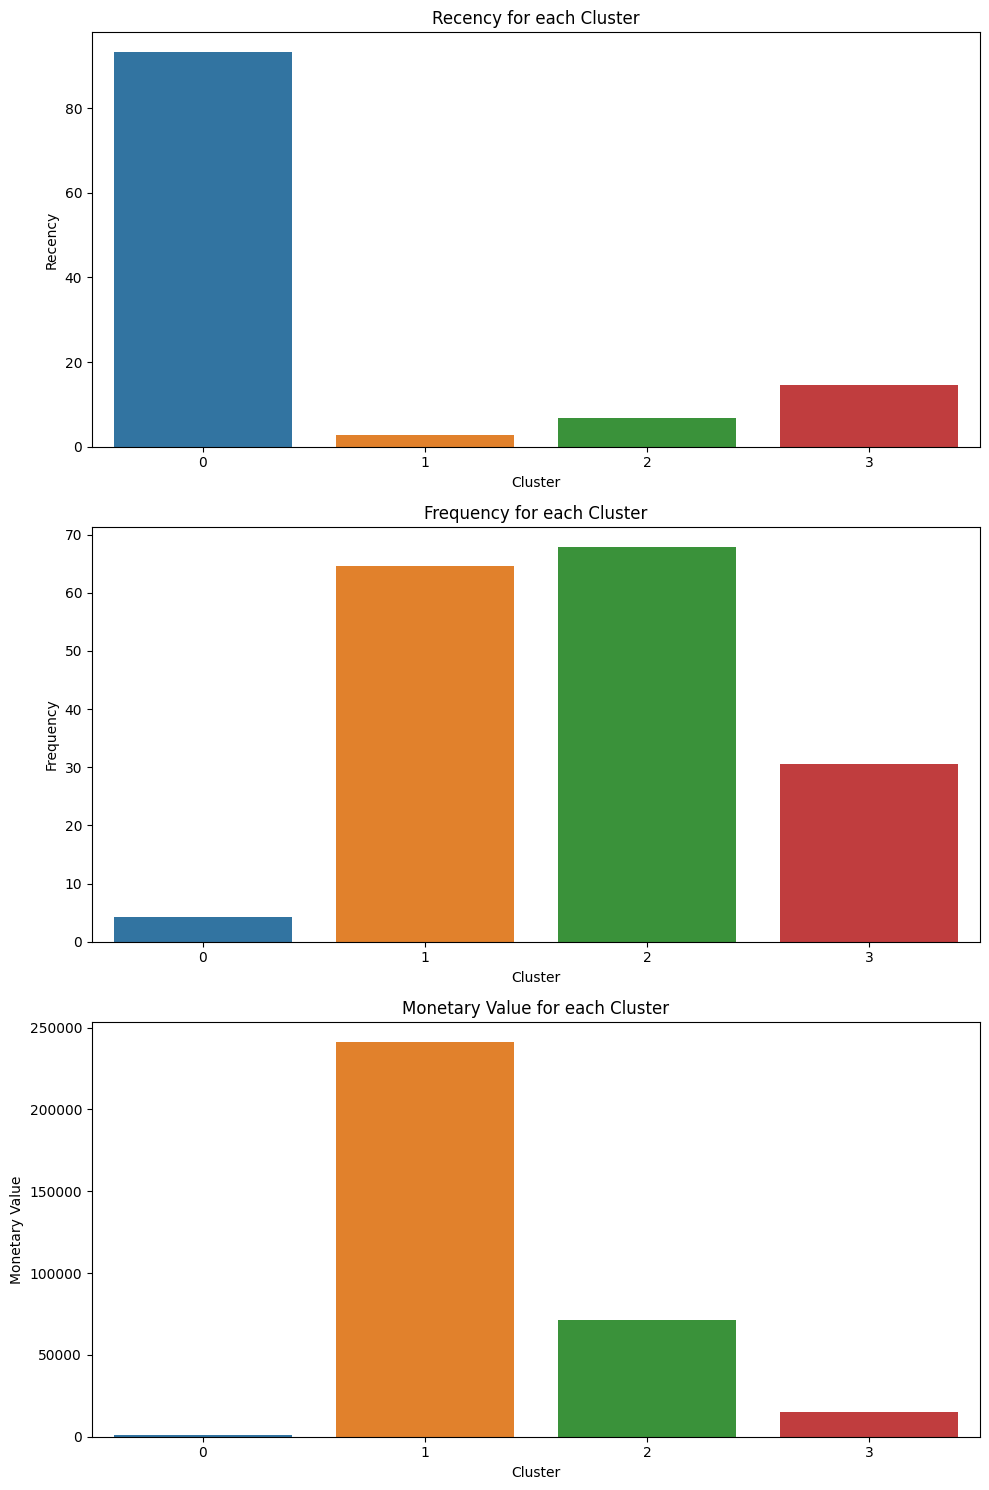

In [ ]:
import seaborn as sns

cluster_avg = rfm.groupby('Cluster').mean()

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, (component, ax) in enumerate(zip(cluster_avg.columns, axs.flatten())):
    sns.barplot(x=cluster_avg.index, y=cluster_avg[component], ax=ax)
    ax.set_title(f'{component} for each Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(component)

plt.tight_layout()
plt.show()